# Combine Odds Data
Combine betting odds data to get a feel for how 'profitable' the model is, explore different betting strategies.

## Reloading previous model

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [7]:
nba_games = pd.read_csv('data/04_improved_model_with_moneylines.csv')
nba_games.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GAME_DATE_EST         5824 non-null   object 
 1   GAME_ID               5824 non-null   float64
 2   HOME_TEAM_ID          5824 non-null   float64
 3   AWAY_TEAM_ID          5824 non-null   float64
 4   SEASON                5824 non-null   float64
 5   HOME_TEAM_POINTS      5824 non-null   float64
 6   AWAY_TEAM_POINTS      5824 non-null   float64
 7   HOME_WIN_PCT          5824 non-null   float64
 8   HOME_HOME_WIN_PCT     5824 non-null   float64
 9   AWAY_WIN_PCT          5824 non-null   float64
 10  AWAY_AWAY_WIN_PCT     5824 non-null   float64
 11  HOME_TEAM_WINS        5824 non-null   bool   
 12  HOME_TEAM_B2B         5824 non-null   bool   
 13  AWAY_TEAM_B2B         5824 non-null   bool   
 14  GAME_DATETIME         5824 non-null   float64
 15  HOME_LAST_10_WIN_PCT 

### Use probability score to determine how much to wager
If probability score of a matchup is determined to be above a certain threshold, try doubling the wager

In [8]:
feat_cols = [
  "GAME_DATETIME",
  "HOME_TEAM_ID",
  "AWAY_TEAM_ID",
  "HOME_WIN_PCT",
  "HOME_HOME_WIN_PCT",
  "AWAY_WIN_PCT",
  "AWAY_AWAY_WIN_PCT",
  "HOME_TEAM_B2B",
  "AWAY_TEAM_B2B",
  "HOME_LAST_10_WIN_PCT",
  "AWAY_LAST_10_WIN_PCT"
]

target = "HOME_TEAM_WINS"

In [31]:
def apply_win_odds(row, wager=10.0):
  if row["HOME_WIN_PROB"] > 0.8 or row["AWAY_WIN_PROB"] > 0.8:
    wager = wager * 2

  row["WAGER"] = wager
  if row["PREDICTION"] == 1 and row["HOME_TEAM_WINS"] == 1: # Correct home predictions
    home_odds = row["FANDUEL_HOME_ODDS"] or row["BETMGM_HOME_ODDS"] or row["CAESARS_HOME_ODDS"] or row["DRAFKINGS_HOME_ODDS"]
    if home_odds is None:
      row["RETURN"] = 0
    if home_odds < 0:
      row["RETURN"] = wager * (100 / abs(home_odds))
    else:
      row["RETURN"] = wager * (home_odds / 100)
  elif row["PREDICTION"] == 0 and row["HOME_TEAM_WINS"] == 0: # Correct away predictions
    away_odds = row["FANDUEL_AWAY_ODDS"] or row["BETMGM_AWAY_ODDS"] or row["CAESARS_AWAY_ODDS"] or row["DRAFKINGS_AWAY_ODDS"]
    if away_odds is None:
      row["RETURN"] = 0
    if away_odds < 0:
      row["RETURN"] = wager * (100 / abs(away_odds))
    else:
      row["RETURN"] = wager * (away_odds / 100)
  else: # Incorrect predictions
    row["RETURN"] = -wager
  return row

def calculate_season_profitability(s):
  season = nba_games.loc[(nba_games['SEASON'] == s)].sort_values(by="GAME_DATETIME")
  train_1, test_1, test_2 = np.array_split(season, 3)
  train = pd.concat([train_1])
  X_train, y_train = train[feat_cols], train[target]

  test = pd.concat([test_1, test_2])
  X_test, y_test = test[feat_cols], test[target]
  clf = RandomForestClassifier(random_state=42, n_jobs=2, n_estimators=1000, max_depth=7, bootstrap=True)
  clf.fit(X_train, y_train)
  print('Train accuracy:',clf.score(X_train, y_train))
  print('Test accuracy:', clf.score(X_test, y_test))

  test["PREDICTION"] = clf.predict(X_test)
  test[["AWAY_WIN_PROB", "HOME_WIN_PROB"]] = clf.predict_proba(X_test)
  test = test.apply(apply_win_odds, axis=1)
  profit = test["RETURN"].sum()
  wager = test["WAGER"].sum()

  plt.plot(test["GAME_DATE_EST"].unique(), test.groupby("GAME_DATE_EST")["RETURN"].sum().cumsum())
  ax = plt.gca()
  ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)
  plt.locator_params(axis='x', nbins=5)
  plt.show()
  return (profit, wager, profit / (wager))

/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9536585365853658
Test accuracy: 0.7402439024390244


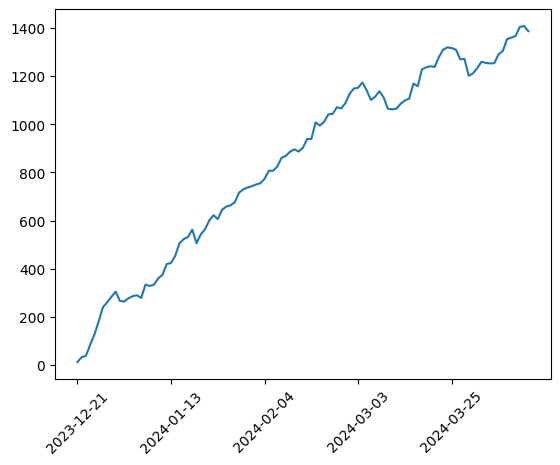

(np.float64(1386.8899786112652),
 np.float64(10640.0),
 np.float64(0.13034680250105876))

In [32]:
calculate_season_profitability(2023)

## Initial season by season profitability
Looking at updated season by season profitability using an updated betting strategy.

******* CALCULATING SEASON **********
2020


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9694444444444444
Test accuracy: 0.7298050139275766


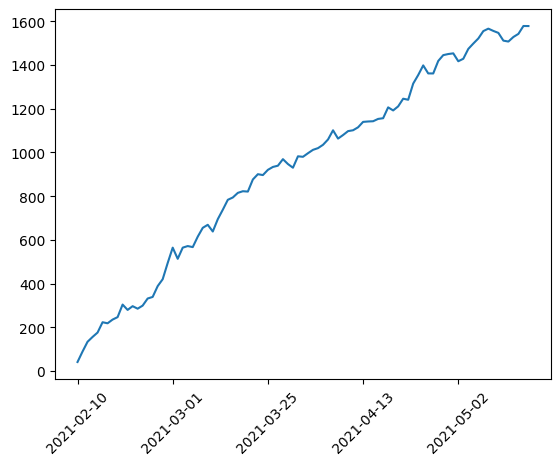

Profit: 1578.196124905393
Total Wagered: 9330.0
Profitability: 0.1691528536876091
******* CALCULATING SEASON **********
2021


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9585365853658536
Test accuracy: 0.7341463414634146


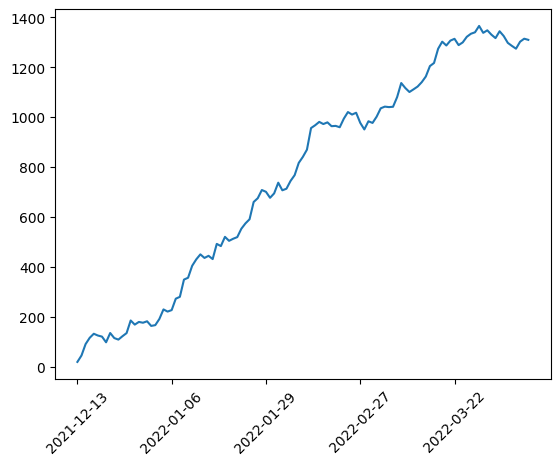

Profit: 1309.4612156685857
Total Wagered: 9750.0
Profitability: 0.13430371442754727
******* CALCULATING SEASON **********
2022


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9318734793187348
Test accuracy: 0.6792682926829269


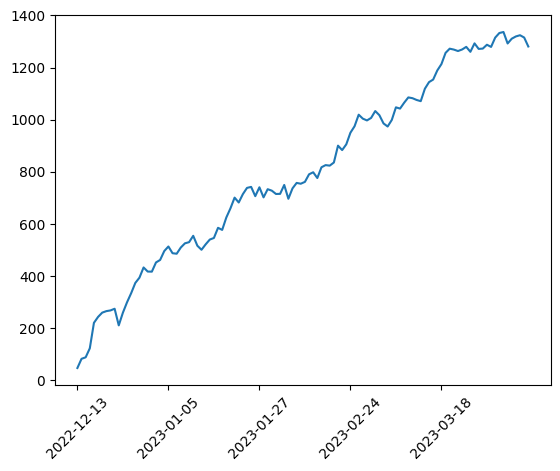

Profit: 1280.6800435622033
Total Wagered: 10210.0
Profitability: 0.12543389261138133
******* CALCULATING SEASON **********
2023


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9536585365853658
Test accuracy: 0.7402439024390244


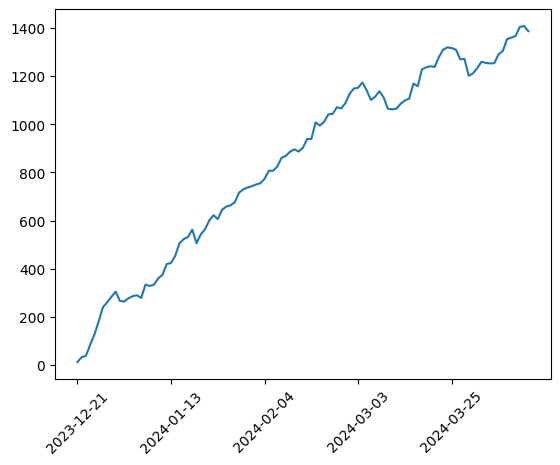

Profit: 1386.8899786112652
Total Wagered: 10640.0
Profitability: 0.13034680250105876


In [24]:
for i in range(2020, 2024):
  print("******* CALCULATING SEASON **********")
  print(i)
  profit, total_wagers, profitability = calculate_season_profitability(i)
  print(f"Profit: {profit}")
  print(f"Total Wagered: {total_wagers}")
  print(f"Profitability: {profitability}")

# Results

Initial strategy examined was betting double on games that have a higher confidence score than 0.8. Compared with the results in `04_combine_odds_data`, there is *marginal* improvement in some years. Postponing this exploration to after initial launch.

Things to consider:
* Higher probability of a moneyline win *likely* means worse payout odds
* May be worth trying to identify the model to identify possible outlier games based on odds